In [1]:
from collections import Counter
import re

import pandas as ps
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
fastqc_summary_table = '../data/fastqc_all_samples.tsv'
table = ps.read_csv(fastqc_summary_table, sep='\t', header=0)
table = table.set_index(table.columns[0])

VM_stats_table = '../data/VM_stats.csv'
VM_table = ps.read_csv(VM_stats_table, sep=',', header=0)
VM_table = VM_table.set_index(VM_table.columns[0])

plot_dir = '../figs/qc_plots/'

In [3]:
def batchnum_from_batchname(bname):
    return int(re.findall(r'batch([\d]+)_',bname)[0])

def samplename_from_batchname(bname):
    return re.findall(r'(gc_[\d]+|VM[\d]+)', bname)[0]

In [4]:
# The 'gc' ID samples also have 'VM' IDs. We can collect them from the VM_stats table
VM_table_sample_IDs = set(list(VM_table.index))
our_sample_IDs = set(map(samplename_from_batchname, table.index))
new_VM_IDs = VM_table_sample_IDs.difference(our_sample_IDs)
our_gc_IDs = set(filter(lambda s: 'gc' in s, our_sample_IDs))
assert(len(our_gc_IDs) == len(new_VM_IDs))

gc2VM = {gc: None for gc in our_gc_IDs}
for VMID in new_VM_IDs:
    t = VM_table[(VM_table.index == VMID) & (VM_table.batch != 'merged')]
    gcIDs = list(set(map(samplename_from_batchname, ';'.join(t['source files']).split(';'))))
    assert(len(gcIDs) == 1)
    gcID = gcIDs[0]
    assert(gc2VM[gcID] == None)
    gc2VM[gcID] = VMID

assert(len(set(gc2VM.keys())) == len(set(our_gc_IDs)))

In [5]:
batchnums = list(map(batchnum_from_batchname, table.index))
assert(len(batchnums) == len(table.index))
table['batch'] = ps.Series(batchnums, index=table.index)

samplenames = list(map(samplename_from_batchname, table.index))
for i, s in enumerate(samplenames): # translate our gc IDs to VM IDs
    if s in gc2VM:
        samplenames[i] = gc2VM[s]
assert(len(samplenames) == len(table.index))
table['sample'] = ps.Series(samplenames, index=table.index)

# Check our samples are consistent with Victors
VM_table_sample_IDs = set(list(VM_table.index))
non_matched_sample_IDs = VM_table_sample_IDs.symmetric_difference(set(samplenames))
assert(len(non_matched_sample_IDs) == 0)

## Total numbers of reads

/Users/chris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/chris/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


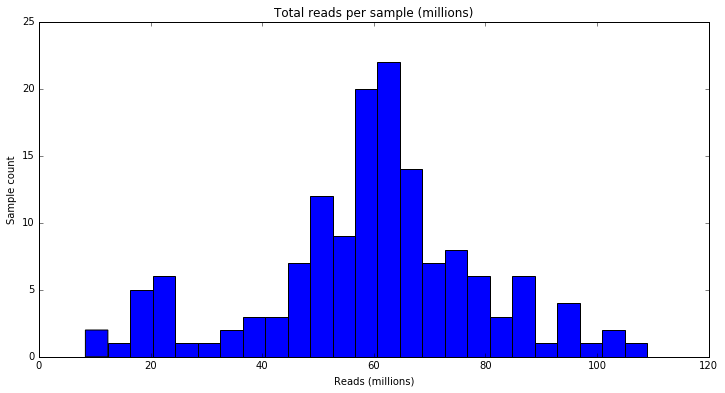

In [6]:
reads = table['total_num_seqs']
reads = table.groupby('sample')['total_num_seqs'].sum()
plt.figure(figsize=(12,6))
plt.hist(reads.as_matrix() / 1.0e6, bins=25)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.title('Total reads per sample (millions)')
plt.xlabel('Reads (millions)')
plt.ylabel('Sample count')

plt.savefig(plot_dir + 'reads_per_sample.png', dpi=300)
plt.show()

median batch
1     5774447
2     6000289
3     3917824
4    10265100
5    29067650
Name: total_num_seqs, dtype: int64
mean batch
1     6984451
2     6072001
3     4151123
4    10231652
5    27556434
Name: total_num_seqs, dtype: int64


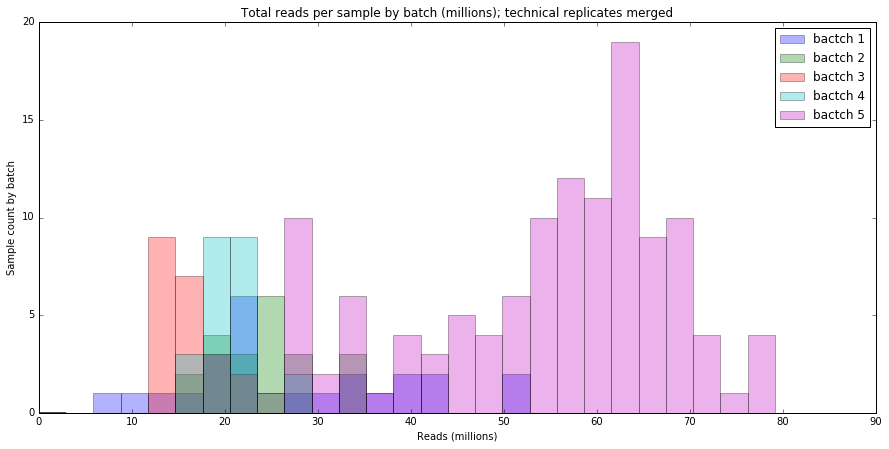

In [66]:
g = table.groupby('batch')
print('median', g['total_num_seqs'].median())
print('mean', g['total_num_seqs'].mean())

numbins = 30

maxreads = table.groupby('sample')['total_num_seqs'].sum().values.max()
maxreads = 85000000
bins = np.linspace(0, maxreads / 1.0e6, numbins)

plt.figure(figsize=(15,7))
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
for name, group in g:
    g2 = group.groupby('sample')
    r = g2['total_num_seqs'].sum().values
    plt.hist(r / 1.0e6, bins=bins, alpha=0.3, label='bactch {}'.format(name))
plt.legend()
plt.title('Total reads per sample by batch (millions); technical replicates merged')
plt.xlabel('Reads (millions)')
plt.ylabel('Sample count by batch')

plt.savefig(plot_dir + 'reads_per_sample_by_batch_tech_reps_merged.png', dpi=300)
plt.show()

In [6]:
sample_cts = Counter(table['sample'].values)
sample_cts = [(k,v) for k, v in sample_cts.items()]
sample_cts = sorted(sample_cts, key=lambda t: t[1])

## Sample thresholding by number of reads

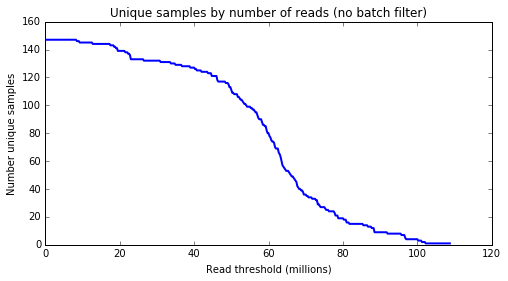

In [56]:
sample_grouped = table.groupby('sample')['total_num_seqs'].sum()

def apply_numreads_millions_thresh(thresh):
    raw_thresh = thresh * 1.0e6
    return len(sample_grouped[sample_grouped > raw_thresh])

threshold_increment_millions = 0.25
maxreads_millions = sample_grouped.values.max() / 1.0e6

threshs = np.arange(0.0, maxreads_millions, threshold_increment_millions)
num_uniques = list(map(apply_numreads_millions_thresh, threshs))

plt.figure(figsize=(8,4))
plt.plot(threshs, num_uniques, linewidth=2.0)
plt.title('Unique samples by number of reads (no batch filter)')
plt.xlabel('Read threshold (millions)')
plt.ylabel('Number unique samples')

plt.savefig(plot_dir + 'num_unique_samples_read_thresh.png', dpi=300)
plt.show()

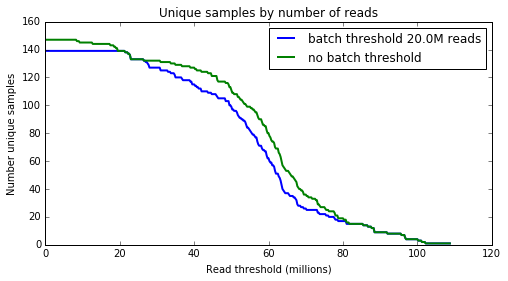

In [63]:
thresh = 20.0e6

counts_per_sample = {s: 0 for s in set(table['sample'])}

g1 = table.groupby('batch')
for _, t in g1:
    t2 = t.groupby('sample')['total_num_seqs'].sum()
    t2 = t2[t2 > thresh]
    for s, v in zip(t2.index, t2):
        counts_per_sample[s] += v

counts = np.array([v for v in counts_per_sample.values()])

def counts_above_thresh(thresh):
    raw_thresh = thresh * 1.0e6
    return counts[counts > raw_thresh].shape[0]

threshs = np.arange(0.0, maxreads_millions, threshold_increment_millions)
num_uniques = list(map(counts_above_thresh, threshs))
num_uniques_no_batch_thresh = list(map(apply_numreads_millions_thresh, threshs))

plt.figure(figsize=(8,4))
plt.plot(threshs, num_uniques, linewidth=2.0, label='batch threshold {}M reads'.format(thresh / 1.0e6))
plt.plot(threshs, num_uniques_no_batch_thresh, linewidth=2.0, label='no batch threshold')
plt.title('Unique samples by number of reads')
plt.xlabel('Read threshold (millions)')
plt.ylabel('Number unique samples')
plt.legend()

plt.savefig(plot_dir + 'num_unique_samples_read_thresh_batch_thresh.png', dpi=300)
plt.show()

In [35]:
len(sample_grouped[sample_grouped > 2000])

147

In [21]:
g2

In [11]:
batchnums

[4,
 4,
 5,
 5,
 2,
 2,
 3,
 3,
 5,
 5,
 3,
 3,
 5,
 5,
 1,
 1,
 2,
 2,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 3,
 5,
 5,
 2,
 2,
 4,
 4,
 5,
 5,
 5,
 5,
 1,
 1,
 5,
 5,
 5,
 5,
 4,
 4,
 2,
 2,
 4,
 4,
 1,
 1,
 5,
 5,
 1,
 2,
 2,
 3,
 5,
 5,
 1,
 5,
 5,
 5,
 4,
 4,
 1,
 2,
 2,
 1,
 4,
 4,
 3,
 3,
 5,
 5,
 2,
 2,
 3,
 3,
 3,
 3,
 4,
 4,
 3,
 2,
 2,
 3,
 2,
 2,
 5,
 5,
 5,
 5,
 2,
 2,
 4,
 4,
 3,
 3,
 3,
 3,
 1,
 5,
 5,
 1,
 5,
 5,
 1,
 3,
 5,
 5,
 3,
 3,
 3,
 5,
 5,
 1,
 5,
 5,
 1,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 3,
 3,
 1,
 1,
 5,
 5,
 5,
 5,
 3,
 1,
 1,
 3,
 5,
 5,
 2,
 2,
 5,
 5,
 5,
 5,
 1,
 1,
 3,
 4,
 4,
 3,
 1,
 1,
 2,
 2,
 3,
 3,
 5,
 5,
 5,
 5,
 1,
 1,
 5,
 1,
 1,
 5,
 3,
 3,
 5,
 5,
 4,
 5,
 1,
 3,
 3,
 1,
 5,
 2,
 2,
 5,
 1,
 5,
 5,
 1,
 3,
 1,
 1,
 3,
 3,
 4,
 5,
 5,
 4,
 2,
 2,
 3,
 5,
 3,
 5,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 5,
 5,
 1,
 2,
 2,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 2,
 5,
 5,
 5,
 5,
 5,
 1,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 3,
 3,
 5,
 2,
 5,
 5,
 2,
 5,
 5,


In [38]:
num_uniques

In [64]:
t = VM_table[(VM_table.index == 'VM1004') & (VM_table.batch != 'merged')]
gcIDs = list(set(map(samplename_from_batchname, ';'.join(t['source files']).split(';'))))
assert(len(gcIDs) == 1)
gcID = gcIDs[0]

In [64]:
table['total_dup_percent'].max()

79.105452280006332